In [117]:
import numpy as np
import pandas as pd
import datetime
from scipy import signal

import matplotlib.pyplot as plt

# read, extract, resampled, sliced

In [118]:
def standardize_sensor_raw_info(path_csv_sensor, data_col_names):
    
    sensor_df = pd.read_csv(path_csv_sensor, names=data_col_names)
    unix_time = sensor_df.iloc[0,0]
    
    sampling_frequency = sensor_df.iloc[1,0]
    
    sensor_df_sliced = sensor_df.iloc[2 :, :]
    
    sensor_df_sliced_copy = sensor_df_sliced.copy()
    
    sensor_df_sliced_copy = sensor_df_sliced_copy.reset_index(drop=True)
    
    sampling_time = 1/sampling_frequency
    
    timestamps = unix_time + (sensor_df_sliced_copy.index)*sampling_time
    
    sensor_df_sliced_copy['timestamps'] = timestamps
    
    sensor_df_sliced_copy['starting_timestamp'] = ''
    
    sensor_df_sliced_copy['starting_timestamp'] = [unix_time]+['']*(len(sensor_df_sliced_copy)-1)
    
    end_time = timestamps[-1]
    sensor_df_sliced_copy['ending_timestamp'] = ''
    sensor_df_sliced_copy['ending_timestamp'] = [end_time]+['']*(len(sensor_df_sliced_copy)-1)
    
    
    sensor_df_sliced_copy['sampling_frequency'] = ''
    
    sensor_df_sliced_copy['sampling_frequency'] =[sampling_frequency]+['']*(len(sensor_df_sliced_copy)-1)
    
    return sensor_df_sliced_copy
    
    

In [119]:
def resample_sensor_data(original_standardize_df,  sensor_cols, new_sampling_frequency):
    
    
    orignal_sampling_frequecy = original_standardize_df["sampling_frequency"][0]
    
    multiplier = new_sampling_frequency/orignal_sampling_frequecy
    
    total_new_samples = multiplier * len(original_standardize_df)
    
    new_df = pd.DataFrame()
    
    
    for sensor_col in sensor_cols:
        
        #print(sensor_col)
        
        signal_array=original_standardize_df[sensor_col].values
        
        signal_array_resampled = signal.resample(signal_array, int(total_new_samples))
        
        
        new_df[sensor_col] = signal_array_resampled
        
        
    new_sampling_time = 1/new_sampling_frequency
    
    starting_time = original_standardize_df["starting_timestamp"][0]
    
    timestamps = starting_time + (new_df.index)*new_sampling_time
    
    
    
    new_df['timestamps'] = timestamps
    
    
    new_df['starting_timestamp'] = ''
    new_df['starting_timestamp'] = [starting_time]+['']*(len(new_df)-1)
    
    end_time = timestamps[-1]
    new_df['ending_timestamp'] = ''
    new_df['ending_timestamp'] = [end_time]+['']*(len(new_df)-1)
    
    new_df['sampling_frequency'] = ''
    new_df['sampling_frequency'] =[new_sampling_frequency]+['']*(len(new_df)-1)
    
    
    return new_df
        

In [120]:
def magnitude_acc_sensor(std_acc_df):    
    magnitude= np.sqrt(std_acc_df.iloc[:,0]**2 + std_acc_df.iloc[:,1]**2 + std_acc_df.iloc[:,2]**2)
    std_acc_df['magnitude'] = magnitude
    return std_acc_df

In [121]:
def normalize_signal (std_df, signal_col):
    
    signal = std_df[signal_col]
    
    mean_signal = np.mean(signal)
    
    mean_sub = signal - mean_signal
    
    scaled_data =  mean_sub/np.max(np.abs(mean_sub))
    
    std_df["mean_norm"] = scaled_data
    
    return std_df
    


In [122]:
def get_start_stop_timestamps(list_dfs):
    
    starting_time_list = [df["starting_timestamp"][0] for df in list_dfs]
    ending_time_list  = [df["ending_timestamp"][0] for df in list_dfs]
    
    late_start = max(starting_time_list)
    early_stop =min(ending_time_list)
    
    return late_start, early_stop

In [123]:
def sync_slice_df(df, start_time, stop_time):
    
    sliced_df=df[(df.timestamps>=start_time)&(df.timestamps <= stop_time)]
    
    sliced_df =sliced_df.copy()
    
    return sliced_df

# Testing on the data 

### Accelorometer data

In [124]:
acc_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/ACC.csv"
data_col_names = ['x', 'y', 'z']

In [125]:
acc_df_stand=standardize_sensor_raw_info (acc_sensor_path, data_col_names)
acc_df_stand = magnitude_acc_sensor(standardize_acc_df)
acc_df_stand_norm = normalize_signal(standardize_acc_df, 'magnitude')

## Heart rate data

In [126]:
hr_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/HR.csv"
data_col_names = ['signal']

In [127]:
hr_df_stand=standardize_sensor_raw_info(hr_sensor_path, data_col_names)
hr_df_stand_resamp = resample_sensor_data(hr_df_standardize,  ["signal"], 32)
hr_df_stand_resamp_norm = normalize_signal (resampled_standardized_hr_df, "signal")

### Eda Data

In [128]:
eda_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/EDA.csv"
data_col_names = ['signal']

In [129]:
eda_df_stand=standardize_sensor_raw_info(eda_sensor_path, data_col_names)
eda_df_resamp_stand = resample_sensor_data(eda_df_standardize,  ["signal"], 32)
eda_df_stand_resamp_norm = normalize_signal (resampled_standardized_eda_df, "signal")

## slicing & Synchronizing data of all the sensors 

In [148]:
list_dfs = [acc_df_stand_norm, hr_df_stand_resamp_norm, eda_df_stand_resamp_norm]

In [149]:
start_time, stop_time = get_start_stop_timestamps(list_dfs)    

In [150]:
acc_df_sliced_synced= sync_slice_df(acc_df_stand_norm, start_time, stop_time)

In [151]:
eda_df_sliced_synced = sync_slice_df(eda_df_stand_resamp_norm, start_time, stop_time)

In [153]:
hr_df_sliced_synced= sync_slice_df(hr_df_stand_resamp_norm, start_time, stop_time)

In [159]:
hr_df_sliced_synced.shape 

(124096, 6)

In [160]:
eda_df_sliced_synced.shape

(124096, 6)

In [178]:
eda_df_sliced_synced

signal    timestamps starting_timestamp ending_timestamp  \
320     0.055091  1.695387e+09                                       
321     0.042985  1.695387e+09                                       
322     0.032790  1.695387e+09                                       
323     0.026044  1.695387e+09                                       
324     0.023751  1.695387e+09                                       
...          ...           ...                ...              ...   
124411  5.314990  1.695391e+09                                       
124412  4.121475  1.695391e+09                                       
124413  2.929519  1.695391e+09                                       
124414  1.806666  1.695391e+09                                       
124415  0.813920  1.695391e+09                                       

       sampling_frequency  mean_norm  
320                        -0.322092  
321                        -0.323655  
322                        -0.324971  
323                        -0.325841  
324                        -0.326138  
...                   ...        ...  
124411                      0.356929  
124412                      0.202854  
124413                      0.048979  
124414                     -0.095974  
124415                     -0.224132  

[124096 rows x 6 columns]

In [161]:
acc_df_sliced_synced.shape

(124096, 9)

In [169]:
acc_df_sliced_synced

x     y     z    timestamps starting_timestamp ending_timestamp  \
320     24.0  -7.0  57.0  1.695387e+09                                       
321     24.0  -7.0  57.0  1.695387e+09                                       
322     25.0  -7.0  57.0  1.695387e+09                                       
323     24.0  -7.0  57.0  1.695387e+09                                       
324     24.0  -7.0  57.0  1.695387e+09                                       
...      ...   ...   ...           ...                ...              ...   
124411  11.0  12.0  61.0  1.695391e+09                                       
124412  12.0  12.0  61.0  1.695391e+09                                       
124413  13.0  14.0  61.0  1.695391e+09                                       
124414  10.0  14.0  60.0  1.695391e+09                                       
124415   9.0  12.0  59.0  1.695391e+09                                       

       sampling_frequency  magnitude  mean_norm  
320                        62.241465  -0.006782  
321                        62.241465  -0.006782  
322                        62.633857  -0.002078  
323                        62.241465  -0.006782  
324                        62.241465  -0.006782  
...                   ...        ...        ...  
124411                     63.134776   0.003927  
124412                     63.316664   0.006107  
124413                     63.921827   0.013362  
124414                     62.417946  -0.004667  
124415                     60.876925  -0.023141  

[124096 rows x 9 columns]

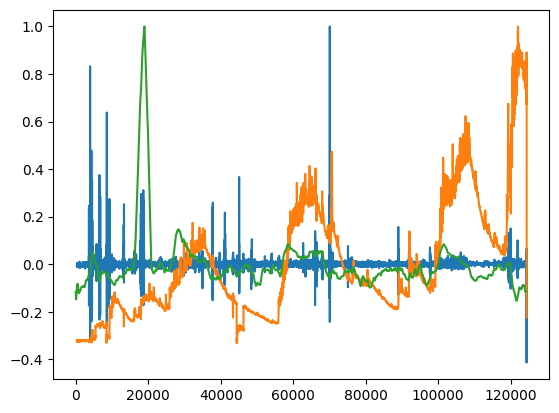

In [180]:
fsz = 26
fsz_fig= 32
fig, ax = plt.subplots()

##---------------------------------------------

ax.plot(acc_df_sliced_synced["mean_norm"])
ax.plot(eda_df_sliced_synced["mean_norm"])
ax.plot(hr_df_sliced_synced["mean_norm"])


## Behavioral Data

In [185]:
tags_path = "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/psychopy/WP2_01_IGFW_SAM_Experiment_2023-09-18_11h14.57.361.csv"

In [186]:
tags_df = pd.read_csv(tags_path)

In [188]:
tags_df.columns

Index(['task', 'correct_response', 'difficulty_level', 'fam_loop.thisRepN',
       'fam_loop.thisTrialN', 'fam_loop.thisN', 'fam_loop.thisIndex',
       'pa_loop.thisRepN', 'pa_loop.thisTrialN', 'pa_loop.thisN',
       ...
       'timestamp', 'TotalReward', 'EndofExp', 'participant', 'session',
       'date', 'expName', 'psychopyVersion', 'frameRate', 'Unnamed: 193'],
      dtype='object', length=194)